# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [44]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from scripts import *

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder


In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [47]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [48]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [49]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

# 3 Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## 3.1 Read the Train and Test Data - Low Carb

In [149]:
X_train = load_dataset(context, 'train/theme_low_carb/features_low_carb')
y_train = load_dataset(context, 'train/theme_low_carb/target_low_carb')
print(X_train.shape, y_train.shape)

X_test = load_dataset(context, 'test/theme_low_carb/features_low_carb')
y_test = load_dataset(context, 'test/theme_low_carb/target_low_carb')
print(X_test.shape, y_test.shape)

(156, 9) (156, 1)
(40, 9) (40, 1)


## 3.2 Feature Engineering Pipelines


#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [150]:
# collecting different types of columns for transformations
cat_columns = X_train.select_dtypes('object').columns
num_columns = X_train.select_dtypes('number').columns

#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [151]:
outlier_transformer = Outlier(method='mean')
train_X = outlier_transformer.fit_transform(X_train)

#### Scaling


In [152]:
# Scaling the training and test sets
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Retaining column names after standardization
X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns)

y_train = pd.DataFrame(y_train).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)

### 3.2.1 Univariate


- Look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target

In [153]:
out = eda.get_density_plots(X_train)
out

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [Average Price A]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [154]:
# save the plots are html
reports.create_report({'univariate': out}, name='feature_analysis_univariate')

A report containing the above plot is available [here](https://drive.google.com/file/d/16ntqUc_zvpg0at5pTtO-ljBjw5UVGFnp/view?usp=sharing)


Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1vUaCcs1PJ4IYo1em9-eZIEj9WuDsnFKT/view?usp=sharing)

In [155]:
reports.feature_analysis(X_train,'./feature_analysis_report.html')

### 3.2.2 Bivariate - mutual interactions

- Find columns with high correlations and drop them

In [156]:
out = eda.get_correlation_table(X_train)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,Average Price A,Average Price D,-0.779486,0.779486
1,Average Price D,Average Price H,0.689400,0.689400
2,Average Price B,Average Price H,-0.625104,0.625104
3,Average Price D,total_5W,-0.606294,0.606294


In [157]:
%%time
# create reports as needed
cols = X_train.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(X_train, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='feature_analysis_bivariate')

CPU times: user 2.01 s, sys: 8.13 ms, total: 2.02 s
Wall time: 2.01 s


A report containing the bivariate plot is available [here](https://drive.google.com/file/d/1WSGT3586tY-rOmZ57xGILbmL5ll9cSVT/view?usp=sharing)

Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1A2fz_bjYv8I3iaFDT75JQSDKeJEXxCtp/view?usp=sharing)

In [158]:
reports.feature_interactions(X_train,'./feature_interaction_report.html')

### 3.2.3 Key Drivers - Interaction with Target variable

In [159]:
out = eda.get_target_correlation(X_train, y_train, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
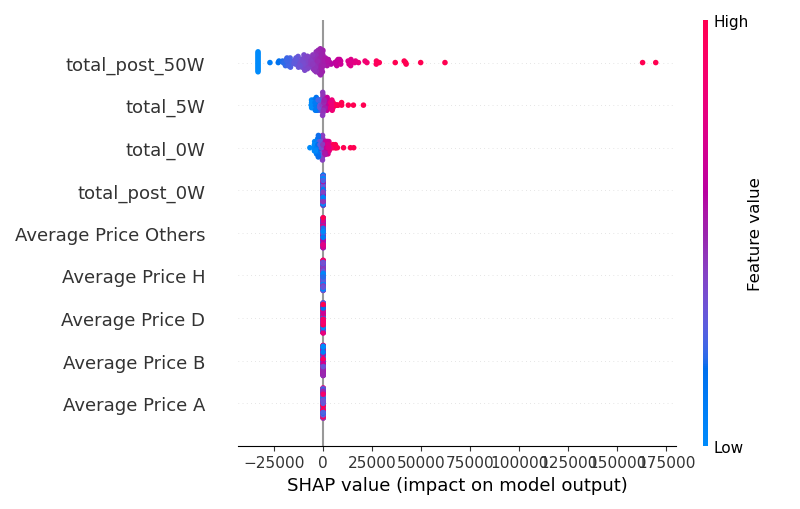

In [160]:
out = eda.get_feature_importances(X_train, y_train, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Key drivers report like feature importance, bivariate plots can be obtained as below

In [161]:
reports.key_drivers(X_train,y_train, './key_drivers_report.html', y_continuous=True)

**Dev Notes**
<details>
    
- The SHAP plots and bivariate plots in key drivers reports can be obtained by including quick=False as a parameter to key_drivers function call. 
- SHAP plots and bivariate plots often take long depending on data shape.
- The plot with shap is present [here](https://drive.google.com/file/d/1JOTMBLiv3LEqZ-kxZz0RokW9v5UyiGva/view?usp=sharing)

</details>


All the plots like feature analysis, interaction, key drivers can be obtained as a single plot using data exploration method as shown below. The output from this is available [here](https://drive.google.com/file/d/1209MzmSSEhiTYuPfHpaVXFXUVbkaJm0B/view?usp=sharing)

In [162]:
reports.data_exploration(X_train,y_train,'./data_exploration_report.html', y_continuous=True)

# 4 Modelling

## 4.1 Modelling - Linear Regression

### 4.1.1 Feature Selection(Specific to Regression)

- Selecting Features specific to regression
- Removed highly corelated variables
- Removed Units because of causality

In [163]:
X_train = remove_correlated_vars(X_train)

### 4.1.2 Data transformations

In [164]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [165]:
reg_ppln_ols = Pipeline([
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(X_train1, y_train.values.ravel())


Pipeline(steps=[('estimator', SKLStatsmodelOLS())])

In [166]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     65.16
Date:                Mon, 03 Jul 2023   Prob (F-statistic):           3.36e-39
Time:                        13:55:15   Log-Likelihood:                -2008.8
No. Observations:                 156   AIC:                             4032.
Df Residuals:                     149   BIC:                             4053.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept             2.791e+06   3.32e+05      8.419      0.000    2.14e+06    3.45e+06
Average Price A      -1.471e+05   3.61e+04     -4.080      0.000   -2.18e+05   -7.58e+04
Average Price B       3.012e+05   3.49e+04      8.619      0.000    2.32e+05     3.7e+05
Average Price H      -1.066e+05   1.21e+04     -8.779      0.000   -1.31e+05   -8.26e+04
Average Price Others  -1.11e+05   4.89e+04     -2.268      0.025   -2.08e+05   -1.43e+04
total_0W                -0.5165      0.542     -0.954      0.342      -1.587       0.554
total_post_50W           5.8904      5.744      1.026      0.307      -5.459      17.240
==============================================================================
Omnibus:                       13.173   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               25.071
Skew:                          -0.361   Prob(JB):                     3.60e-06
Kurtosis:                       4.826   Cond. No.                     2.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [168]:
reg_ppln_ols1 = Pipeline([
    ('estimator', SKLStatsmodelOLS())
])

X_train1 = X_train.drop(columns = ['Average Price D','total_5W','total_post_0W'])
X_test1 = X_test.drop(columns = ['Average Price D','total_5W','total_post_0W'])

reg_ppln_ols1.fit(X_train1, y_train.values.ravel())

# Removing low p-value
print(reg_ppln_ols1['estimator'].summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     65.16
Date:                Mon, 03 Jul 2023   Prob (F-statistic):           3.36e-39
Time:                        13:55:20   Log-Likelihood:                -2008.8
No. Observations:                 156   AIC:                             4032.
Df Residuals:                     149   BIC:                             4053.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept             2.791e+06 

### 4.1.5 Model Evaluation(Linear Model)

This will be part of the production code.

In [116]:
reg_ppln_final = Pipeline([
    ('Linear Regression', SKLStatsmodelOLS())
])

reg_ppln_final.fit(X_train1, y_train.values.ravel())

Pipeline(steps=[('Linear Regression', SKLStatsmodelOLS())])

In [117]:
reg_linear_report = RegressionReport(model=reg_ppln_final, x_train=X_train1, y_train=y_train, x_test= X_test1, y_test= y_test, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='regression_linear_model_report')

**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/18RlQTsT1ze09Cgz-qpb4ha_cvyWbN5F5/view?usp=sharing).
</details>

### 4.1.6 Residual Analysis
- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- we took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [76]:
threshold=0.3
residual_analysis = X_test.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(X_test)
residual_analysis['actuals'] = y_test.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [77]:
residual_analysis.hvplot.kde(y="actuals",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="unit_cost",
                                title=f'unit cost(density)',legend='top_right')

:NdOverlay   [forecast_flag]
   :Distribution   [actuals]   (Density)

- From the above plot we can infer that the higher "over predictions" are happening for unit_cost > 200.
- similarly, the higher "under predictions" are happening for unit_cost is zero.

This can help us tune the model by a separate model for unit_cost > 200


# 4.2 Modelling - XGBoost

## 4.2.1 Model training pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.2.2 Model Pipeline Build

In [92]:
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(X_train, y_train)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

### 4.2.3 Model Tuning

<AxesSubplot:>

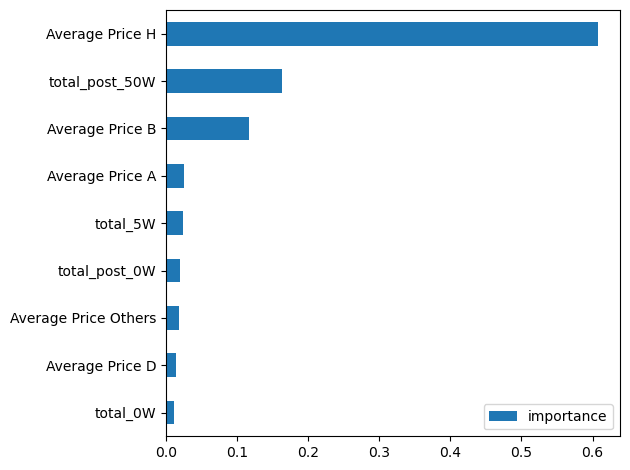

In [93]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = train_X.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

'condition','model_family','days_since_last_purchase','first_time_customer','sales_person', are considered to be important and in grid search

#### Grid Search of the Estimator

In [94]:
%%time
parameters = {
   'gamma':[0.03],
   'min_child_weight':[6],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[500], 
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/raunak314/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/raunak314/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/raunak314/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/raunak314/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pan

0.739444723246002
{'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500}
CPU times: user 6.16 s, sys: 85.9 ms, total: 6.25 s
Wall time: 4min 6s


#### Pipeline Build using the best estimator

In [95]:
xgb_pipeline_final = Pipeline([
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(X_train, y_train)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0.03, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [96]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final, x_train=X_train, y_train=y_train, x_test= X_test, y_test= y_test,)
reg_tree_report.get_report(include_shap=False, file_path='regression_tree_model_report')

The Regression report containing the feature importances are available [here](https://drive.google.com/file/d/1JBfL3uxPcxBfl0amweXBFmLr7CSHFBUO/view?usp=sharing)

# 5 Model Comparison

Now, a comparison report of the  linear (vs) tree -based model  approach can be generated as follows.

This code will not be part of the production code.

In [120]:
model_pipelines = [reg_ppln_final, xgb_pipeline_final]
model_comparison_report = RegressionComparison(models=model_pipelines,x=X_train, y=y_train,refit=True)
metrics = model_comparison_report.get_report(file_path='regression_comparison')

In [121]:
model_comparison_report.performance_metrics

metric,MAPE,WMAPE,MAE,RMSE,R^2
Linear Regression,0.0427,0.0418,70787.9647,94025.4117,0.7276
XGBoost,0.0010,0.0010,1696.6174,2443.9369,0.9998


A report comparing the performance, metrics between Linear model and Tree model are available [here](https://drive.google.com/file/d/1LDibiFap9K4DKME-Y0S0mtI_05lTdaJF/view?usp=sharing)

### Train and Test Data - Chicken Theme

In [169]:
X_train = load_dataset(context, 'train/theme_chicken/features_chicken')
y_train = load_dataset(context, 'train/theme_chicken/target_chicken')
print(X_train.shape, y_train.shape)

X_test = load_dataset(context, 'test/theme_chicken/features_chicken')
y_test = load_dataset(context, 'test/theme_chicken/target_chicken')
print(X_test.shape, y_test.shape)

(156, 9) (156, 1)
(40, 9) (40, 1)


In [170]:
# Scaling the training and test sets
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Retaining column names after standardization
X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns)

y_train = pd.DataFrame(y_train).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)

In [171]:
#Model iteration 1
reg_ppln_ols = Pipeline([
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(X_train_std, y_train.values.ravel())
# Removing low p-value
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     254.4
Date:                Mon, 03 Jul 2023   Prob (F-statistic):           1.55e-84
Time:                        13:56:40   Log-Likelihood:                -1233.9
No. Observations:                 156   AIC:                             2488.
Df Residuals:                     146   BIC:                             2518.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept             6402.8715     54.527    117.425      0.000    6295.107    6510.636
Average Price A      -1645.7065     94.216    -17.467      0.000   -1831.909   -1459.504
Average Price B       -148.3976     70.265     -2.112      0.036    -287.265      -9.531
Average Price D       -970.7970    112.882     -8.600      0.000   -1193.892    -747.702
Average Price F        506.8027    107.904      4.697      0.000     293.548     720.057
Average Price H        -36.3857     62.825     -0.579      0.563    -160.550      87.779
Average Price Others   -16.0474     76.110     -0.211      0.833    -166.468     134.373
Average Price Label   -310.3695     89.842     -3.455      0.001    -487.928    -132.811
total_post_0W           90.9291     65.442      1.389      0.167     -38.407     220.265
total_post_51W          31.5043     67.008      0.470      0.639    -100.927     163.936
==============================================================================
Omnibus:                       16.532   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.557
Skew:                           0.383   Prob(JB):                     2.57e-09
Kurtosis:                       5.345   Cond. No.                         4.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [173]:
# Model iteration 2
#Removing low p-value
reg_ppln_ols1 = Pipeline([
    ('estimator', SKLStatsmodelOLS())
])
X_train_std1 = X_train_std.drop(columns = ['Average Price H','Average Price Others'])
reg_ppln_ols1.fit(X_train_std1, y_train.values.ravel())
# Removing low p-value
print(reg_ppln_ols1['estimator'].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     330.6
Date:                Mon, 03 Jul 2023   Prob (F-statistic):           5.63e-87
Time:                        13:56:50   Log-Likelihood:                -1234.1
No. Observations:                 156   AIC:                             2484.
Df Residuals:                     148   BIC:                             2509.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept            6402.8715    

### Train and Test Data - Salmon Theme

In [174]:
X_train = load_dataset(context, 'train/theme_salmon/features_salmon')
y_train = load_dataset(context, 'train/theme_salmon/target_salmon')
print(X_train.shape, y_train.shape)

X_test = load_dataset(context, 'test/theme_salmon/features_salmon')
y_test = load_dataset(context, 'test/theme_salmon/target_salmon')
print(X_test.shape, y_test.shape)

# Scaling the training and test sets
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Retaining column names after standardization
X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns)

y_train = pd.DataFrame(y_train).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)



(156, 11) (156, 1)
(40, 11) (40, 1)


In [175]:
#Model iteration1
reg_ppln_ols = Pipeline([
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(X_train_std, y_train.values.ravel())
# Removing low p-value
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     32.59
Date:                Mon, 03 Jul 2023   Prob (F-statistic):           9.64e-34
Time:                        13:57:34   Log-Likelihood:                -1870.9
No. Observations:                 156   AIC:                             3766.
Df Residuals:                     144   BIC:                             3802.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept             6.788e+05   3259.272    208.277      0.000    6.72e+05    6.85e+05
Average Price A      -6.259e+04   8523.007     -7.343      0.000   -7.94e+04   -4.57e+04
Average Price B      -9372.6161   5570.617     -1.683      0.095   -2.04e+04    1638.126
Average Price D       1.859e+04   5108.287      3.639      0.000    8494.668    2.87e+04
Average Price F       3033.7599   3918.580      0.774      0.440   -4711.608    1.08e+04
Average Price H       1.416e+04   3934.775      3.599      0.000    6384.585    2.19e+04
Average Price Others -2.129e+04   5630.925     -3.780      0.000   -3.24e+04   -1.02e+04
Average Price Label   1.063e+04   5536.120      1.920      0.057    -312.130    2.16e+04
total_0W             -3124.3028   4344.942     -0.719      0.473   -1.17e+04    5463.801
total_16W             5187.6123   4291.132      1.209      0.229   -3294.131    1.37e+04
total_post_0W         2798.7872   3398.397      0.824      0.412   -3918.399    9515.974
total_post_5W         -580.3067   3724.036     -0.156      0.876   -7941.143    6780.529
==============================================================================
Omnibus:                       31.571   Durbin-Watson:                   2.140
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.389
Skew:                           0.931   Prob(JB):                     7.70e-14
Kurtosis:                       5.413   Cond. No.                         6.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [176]:
# Model iteration 2
#Removing low p-value
reg_ppln_ols1 = Pipeline([
    ('estimator', SKLStatsmodelOLS())
])

X_train_std1 = X_train_std.drop(columns = ['Average Price F','total_0W','total_post_5W'])
X_train_std1 = remove_correlated_vars(X_train_std1)
reg_ppln_ols1.fit(X_train_std1, y_train.values.ravel())
# Removing low p-value
print(reg_ppln_ols1['estimator'].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     45.19
Date:                Mon, 03 Jul 2023   Prob (F-statistic):           6.34e-36
Time:                        13:57:35   Log-Likelihood:                -1871.6
No. Observations:                 156   AIC:                             3761.
Df Residuals:                     147   BIC:                             3789.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept             6.788e+05 